In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import MinMaxScaler

In [281]:
url = "https://raw.githubusercontent.com/DSabarish/telecom_churn/main/raw_data.csv"
df = pd.read_csv(url)

In [282]:
#Data Overview
print("Rows:",df.shape[0])
print ("Columns:",df.shape[1])
print ("\nFeatures:\n",df.columns.tolist())
print ("\nMissingvalues:",df.isnull().sum().values.sum())
print ("\nUnique values:\n",df.nunique())
print (df['Churn'].value_counts())

Rows: 7043
Columns: 21

Features:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missingvalues: 0

Unique values:
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64
Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [284]:
# Observation of data issue
# TotalCharges ---> object to numeric
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors="coerce")

In [285]:
# Convert 'TotalCharges' to numeric, replacing blanks with 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', 0))

In [286]:
# Define ID and response columns
id_col = ['customerID']
response_col = ['Churn']

# Identify categorical features with fewer than 6 unique values, excluding ID and response columns
cat_cols = [col for col in df.nunique()[df.nunique() < 6].keys() if col not in id_col + response_col]

# Identify numerical features by excluding categorical features, ID, and response columns
num_cols = [col for col in df.columns if col not in cat_cols + id_col + response_col]


print("\nid_col :",id_col),
print("\nresponse_col :",response_col)
print("\ncat_cols :",cat_cols),
print("\nnum_cols :",num_cols)


id_col : ['customerID']

response_col : ['Churn']

cat_cols : ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

num_cols : ['tenure', 'MonthlyCharges', 'TotalCharges']


In [287]:
# Display unique values for each categorical feature and the response variable
for col in cat_cols + response_col:
    print(f"{col}: {df[col].unique()}")

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [288]:
#Separating churn and non churn customers
churn     = df[df["Churn"] == "Yes"]
not_churn = df[df["Churn"] == "No"]

In [289]:
plt.style.use("seaborn-v0_8")

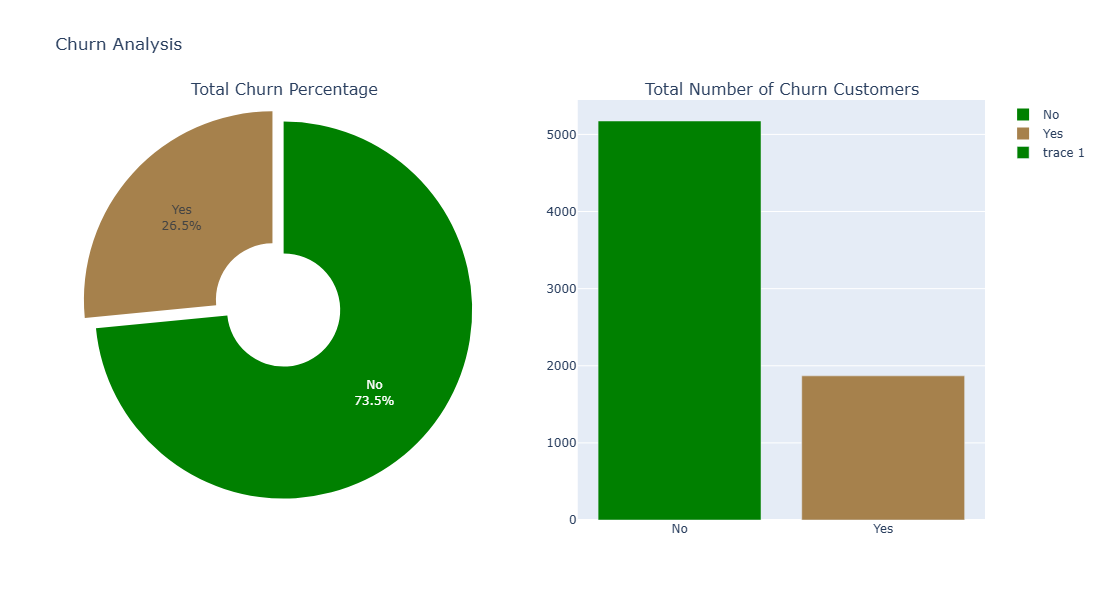

In [290]:
import plotly.graph_objs as go
import plotly.subplots as sp

# Create a subplot with 1 row and 2 columns
fig = sp.make_subplots(rows=1, cols=2, 
                       subplot_titles=('Total Churn Percentage', 'Total Number of Churn Customers'),
                       specs=[[{'type': 'domain'}, {'type': 'xy'}]])

# Pie chart for churn percentage
churn_counts = df['Churn'].value_counts()
fig.add_trace(go.Pie(labels=churn_counts.index, 
                     values=churn_counts.values,
                     hole=.3,  # Optional: adds a donut hole
                     marker=dict(colors=["#008000", "#a6814c"]),
                     textinfo='label+percent',
                     pull=[0, 0.08]),  # Pulls the second slice slightly out
              row=1, col=1)

# Bar chart for total number of churn customers
fig.add_trace(go.Bar(x=churn_counts.index, 
                     y=churn_counts.values,
                     marker=dict(color=["#008000", "#a6814c"])),
              row=1, col=2)

# Update layout for the figure
fig.update_layout(
    title_text='Churn Analysis',
    height=600,
    width=1000
)

# Display the figure
fig.show()


The data shows that 26.54% of the company's customers have decided to terminate the telco's service and left.

In [292]:
import plotly.graph_objs as go
import plotly.offline as py

In [293]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(33, 75, 99)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(33, 75, 99)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non Churn Customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .18, y = -0.25),
                                           dict(text = "Non Churn Customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .85,y = -0.25
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [294]:
import pandas as pd
from scipy.stats import chi2_contingency

def chi_square_test(variable_name, df):
    """
    Perform Chi-Square Test of Independence between a given categorical variable and 'Churn'.
    
    Args:
    variable_name: str. The name of the variable you want to test against 'Churn'.
    df: pandas DataFrame. The DataFrame containing the data.

    Returns:
    None. Prints the contingency table, Chi-Square Statistic, p-value, and the test result.
    """
    # Define the hypotheses
    h0 = f"{variable_name} and churn are independent ({variable_name} has no effect on whether a customer churns)."
    ha = f"{variable_name} and churn are not independent ({variable_name} has a significant effect on whether a customer churns)."

    # Print the hypotheses
    print("Null Hypothesis (H0):", h0)
    print("Alternative Hypothesis (Ha):", ha)
    
    # Create a contingency table for the variable vs Churn
    contingency_table = pd.crosstab(df[variable_name], df['Churn'], margins = True)
    display(contingency_table)
    
    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f"Chi-Square Statistic: {chi2}")
    print(f"p-value: {p}")
    
    # Interpret the p-value
    alpha = 0.05
    result = ("🟩 Reject the null hypothesis: " + ha) if p < alpha else ("🟥 Fail to reject the null hypothesis: " + h0)
    print(result)

In [295]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

# All categorical columns plot pie

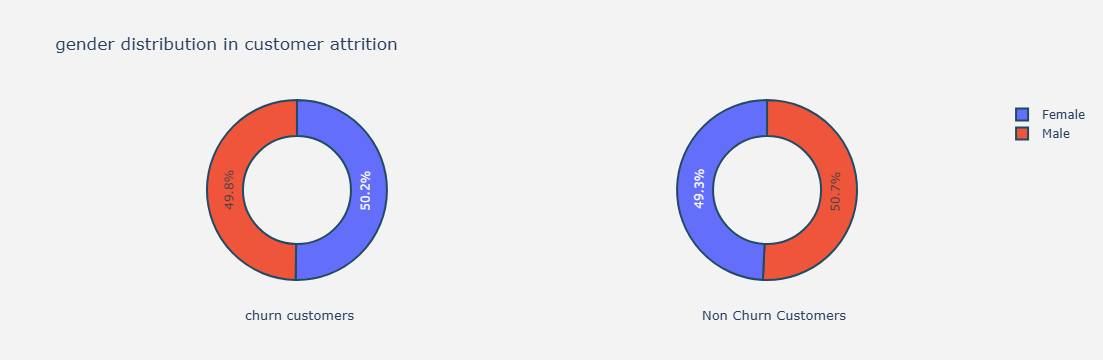

Null Hypothesis (H0): gender and churn are independent (gender has no effect on whether a customer churns).
Alternative Hypothesis (Ha): gender and churn are not independent (gender has a significant effect on whether a customer churns).


Churn,No,Yes,All
gender,,,
Female,2549,939,3488
Male,2625,930,3555
All,5174,1869,7043


Chi-Square Statistic: 0.522366503358827
p-value: 0.9712873885521255
🟥 Fail to reject the null hypothesis: gender and churn are independent (gender has no effect on whether a customer churns).


In [297]:
plot_pie("gender")
chi_square_test('gender', df)

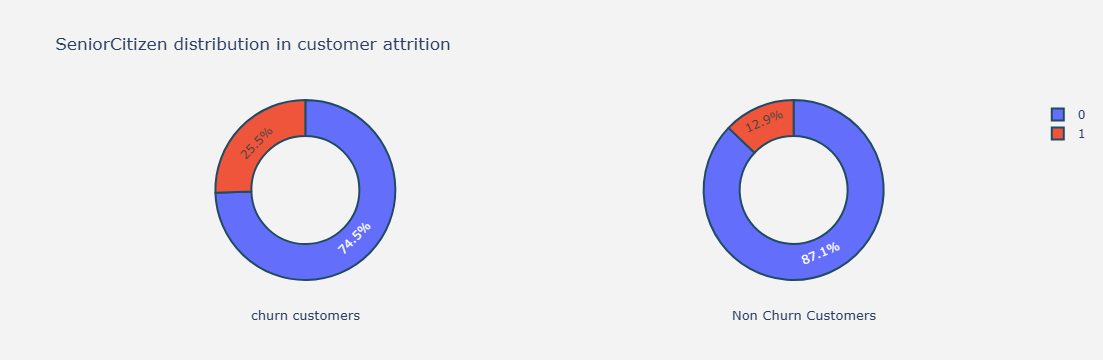

Null Hypothesis (H0): SeniorCitizen and churn are independent (SeniorCitizen has no effect on whether a customer churns).
Alternative Hypothesis (Ha): SeniorCitizen and churn are not independent (SeniorCitizen has a significant effect on whether a customer churns).


Churn,No,Yes,All
SeniorCitizen,,,
0,4508,1393,5901
1,666,476,1142
All,5174,1869,7043


Chi-Square Statistic: 160.35213184520632
p-value: 1.2285843790939117e-33
🟩 Reject the null hypothesis: SeniorCitizen and churn are not independent (SeniorCitizen has a significant effect on whether a customer churns).


In [298]:
plot_pie("SeniorCitizen")
chi_square_test('SeniorCitizen', df)

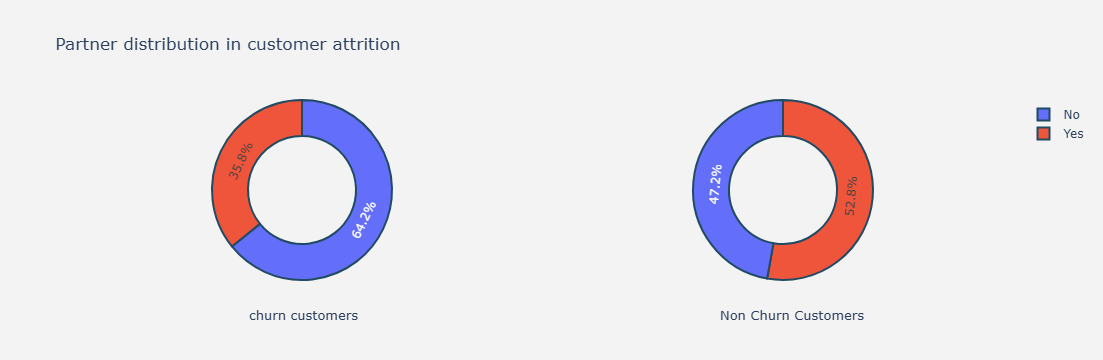

Null Hypothesis (H0): Partner and churn are independent (Partner has no effect on whether a customer churns).
Alternative Hypothesis (Ha): Partner and churn are not independent (Partner has a significant effect on whether a customer churns).


Churn,No,Yes,All
Partner,,,
No,2441,1200,3641
Yes,2733,669,3402
All,5174,1869,7043


Chi-Square Statistic: 159.41452843242658
p-value: 1.952035040461347e-33
🟩 Reject the null hypothesis: Partner and churn are not independent (Partner has a significant effect on whether a customer churns).


In [299]:
plot_pie("Partner")
chi_square_test('Partner', df)

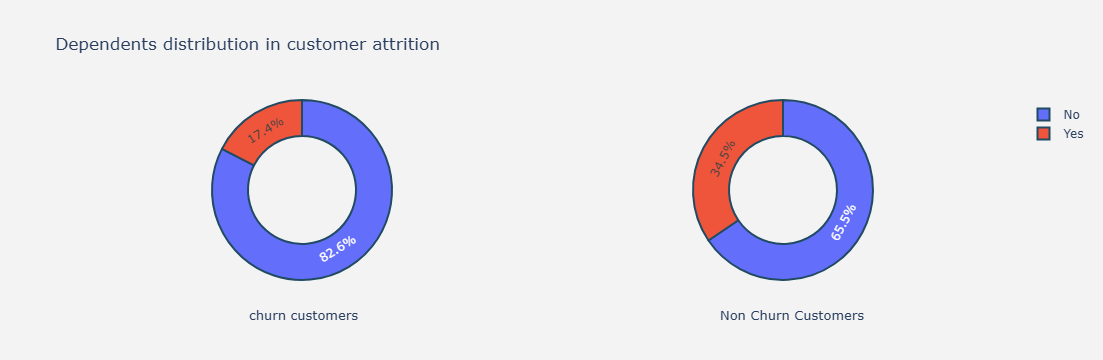

Null Hypothesis (H0): Dependents and churn are independent (Dependents has no effect on whether a customer churns).
Alternative Hypothesis (Ha): Dependents and churn are not independent (Dependents has a significant effect on whether a customer churns).


Churn,No,Yes,All
Dependents,,,
No,3390,1543,4933
Yes,1784,326,2110
All,5174,1869,7043


Chi-Square Statistic: 189.94033391334852
p-value: 5.4590465250260434e-40
🟩 Reject the null hypothesis: Dependents and churn are not independent (Dependents has a significant effect on whether a customer churns).


In [300]:
plot_pie("Dependents")
chi_square_test('Dependents', df)

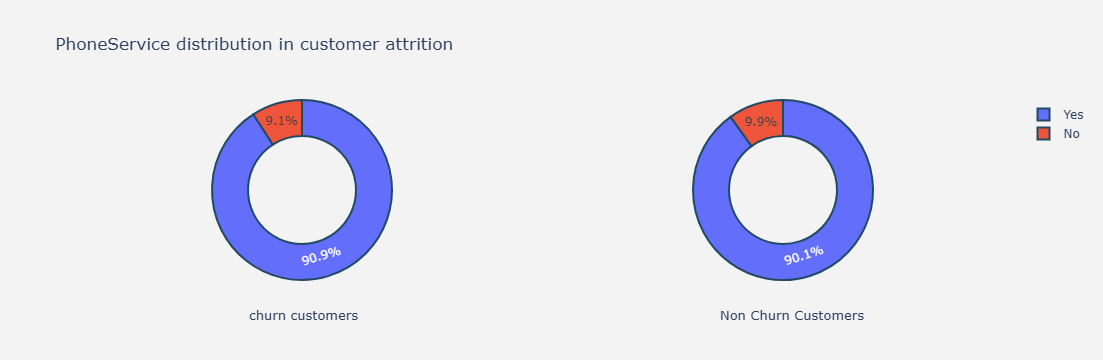

Null Hypothesis (H0): PhoneService and churn are independent (PhoneService has no effect on whether a customer churns).
Alternative Hypothesis (Ha): PhoneService and churn are not independent (PhoneService has a significant effect on whether a customer churns).


Churn,No,Yes,All
PhoneService,,,
No,512,170,682
Yes,4662,1699,6361
All,5174,1869,7043


Chi-Square Statistic: 1.0044084772333213
p-value: 0.9091267853074723
🟥 Fail to reject the null hypothesis: PhoneService and churn are independent (PhoneService has no effect on whether a customer churns).


In [301]:
plot_pie("PhoneService")
chi_square_test('PhoneService', df)

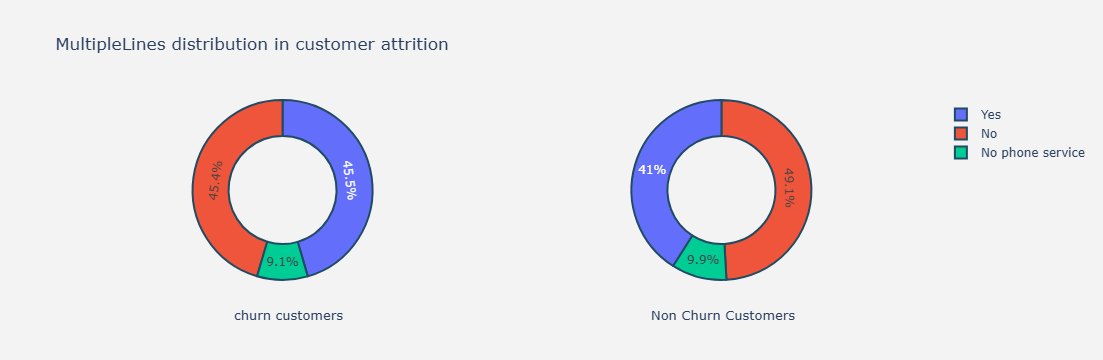

Null Hypothesis (H0): MultipleLines and churn are independent (MultipleLines has no effect on whether a customer churns).
Alternative Hypothesis (Ha): MultipleLines and churn are not independent (MultipleLines has a significant effect on whether a customer churns).


Churn,No,Yes,All
MultipleLines,,,
No,2541,849,3390
No phone service,512,170,682
Yes,2121,850,2971
All,5174,1869,7043


Chi-Square Statistic: 11.33044148319756
p-value: 0.07868508806403089
🟥 Fail to reject the null hypothesis: MultipleLines and churn are independent (MultipleLines has no effect on whether a customer churns).


In [302]:
plot_pie("MultipleLines")
chi_square_test('MultipleLines', df)

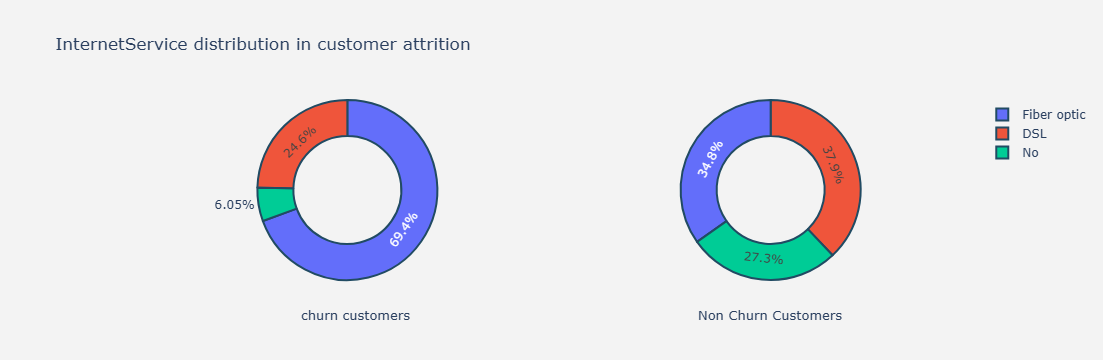

Null Hypothesis (H0): InternetService and churn are independent (InternetService has no effect on whether a customer churns).
Alternative Hypothesis (Ha): InternetService and churn are not independent (InternetService has a significant effect on whether a customer churns).


Churn,No,Yes,All
InternetService,,,
DSL,1962,459,2421
Fiber optic,1799,1297,3096
No,1413,113,1526
All,5174,1869,7043


Chi-Square Statistic: 732.309589667794
p-value: 6.451559630001854e-155
🟩 Reject the null hypothesis: InternetService and churn are not independent (InternetService has a significant effect on whether a customer churns).


In [303]:
plot_pie("InternetService")
chi_square_test('InternetService', df)

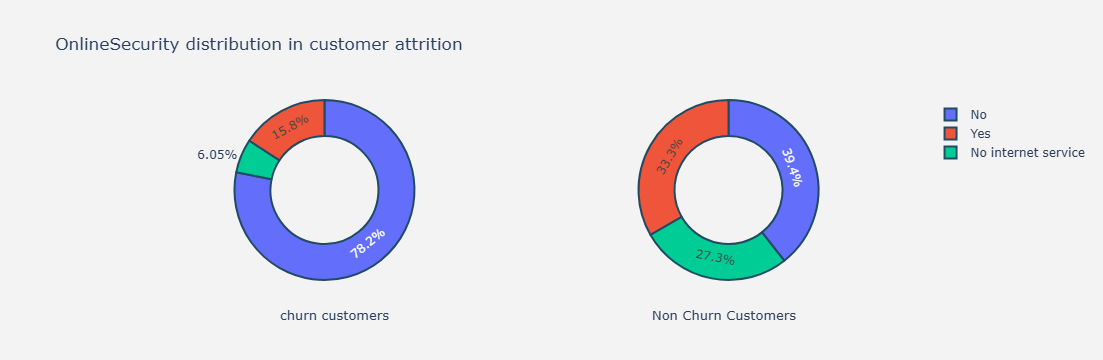

Null Hypothesis (H0): OnlineSecurity and churn are independent (OnlineSecurity has no effect on whether a customer churns).
Alternative Hypothesis (Ha): OnlineSecurity and churn are not independent (OnlineSecurity has a significant effect on whether a customer churns).


Churn,No,Yes,All
OnlineSecurity,,,
No,2037,1461,3498
No internet service,1413,113,1526
Yes,1724,295,2019
All,5174,1869,7043


Chi-Square Statistic: 849.9989679615963
p-value: 2.4146814118679796e-180
🟩 Reject the null hypothesis: OnlineSecurity and churn are not independent (OnlineSecurity has a significant effect on whether a customer churns).


In [304]:
plot_pie("OnlineSecurity")
chi_square_test('OnlineSecurity', df)

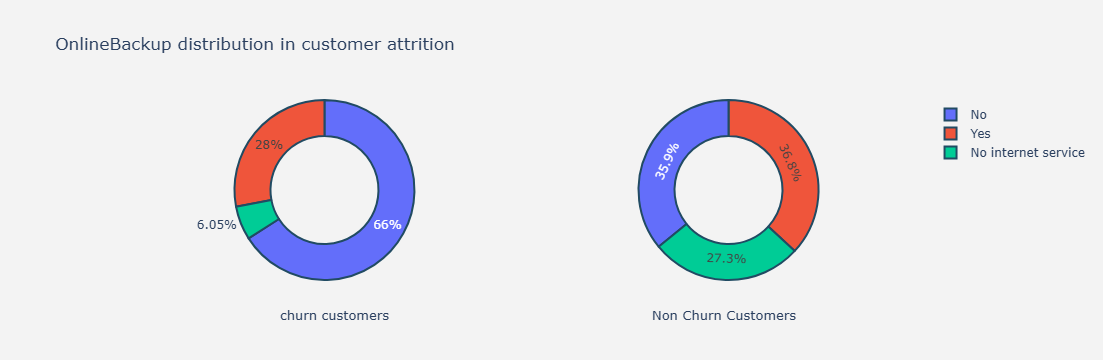

Null Hypothesis (H0): OnlineBackup and churn are independent (OnlineBackup has no effect on whether a customer churns).
Alternative Hypothesis (Ha): OnlineBackup and churn are not independent (OnlineBackup has a significant effect on whether a customer churns).


Churn,No,Yes,All
OnlineBackup,,,
No,1855,1233,3088
No internet service,1413,113,1526
Yes,1906,523,2429
All,5174,1869,7043


Chi-Square Statistic: 601.8127901134089
p-value: 9.47834366883598e-127
🟩 Reject the null hypothesis: OnlineBackup and churn are not independent (OnlineBackup has a significant effect on whether a customer churns).


In [305]:
plot_pie("OnlineBackup")
chi_square_test('OnlineBackup', df)

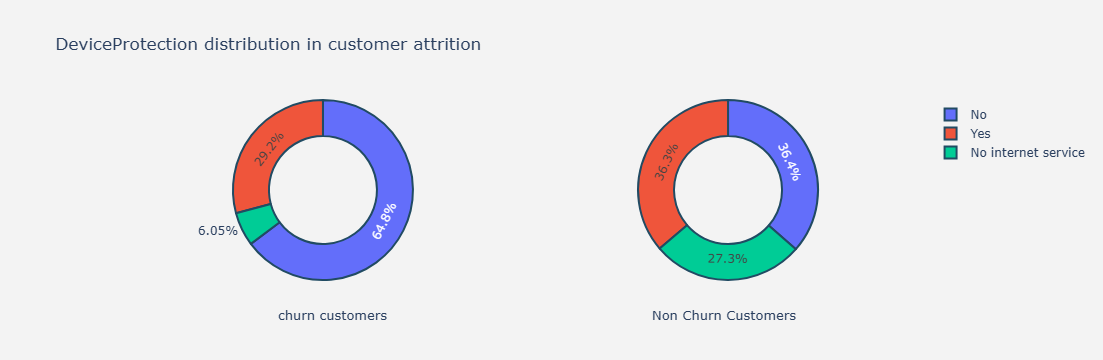

Null Hypothesis (H0): DeviceProtection and churn are independent (DeviceProtection has no effect on whether a customer churns).
Alternative Hypothesis (Ha): DeviceProtection and churn are not independent (DeviceProtection has a significant effect on whether a customer churns).


Churn,No,Yes,All
DeviceProtection,,,
No,1884,1211,3095
No internet service,1413,113,1526
Yes,1877,545,2422
All,5174,1869,7043


Chi-Square Statistic: 558.419369407389
p-value: 2.1613069878600708e-117
🟩 Reject the null hypothesis: DeviceProtection and churn are not independent (DeviceProtection has a significant effect on whether a customer churns).


In [306]:
plot_pie("DeviceProtection")
chi_square_test('DeviceProtection', df)

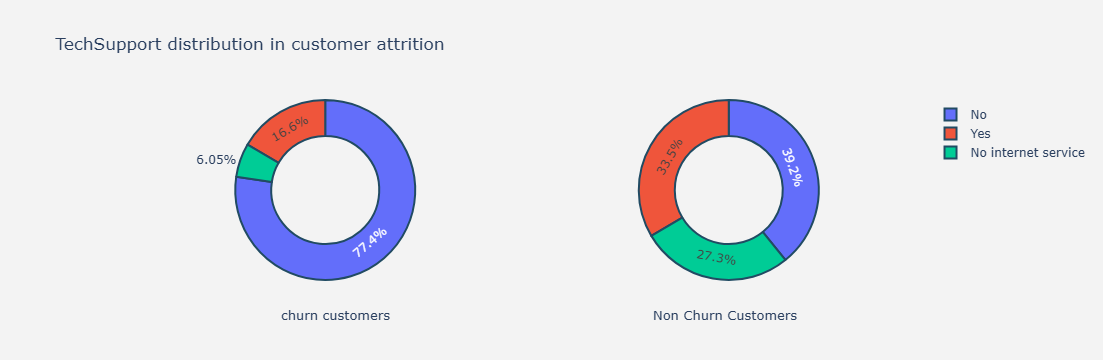

Null Hypothesis (H0): TechSupport and churn are independent (TechSupport has no effect on whether a customer churns).
Alternative Hypothesis (Ha): TechSupport and churn are not independent (TechSupport has a significant effect on whether a customer churns).


Churn,No,Yes,All
TechSupport,,,
No,2027,1446,3473
No internet service,1413,113,1526
Yes,1734,310,2044
All,5174,1869,7043


Chi-Square Statistic: 828.1970684587393
p-value: 1.2432731207524936e-175
🟩 Reject the null hypothesis: TechSupport and churn are not independent (TechSupport has a significant effect on whether a customer churns).


In [307]:
plot_pie("TechSupport")
chi_square_test('TechSupport', df)

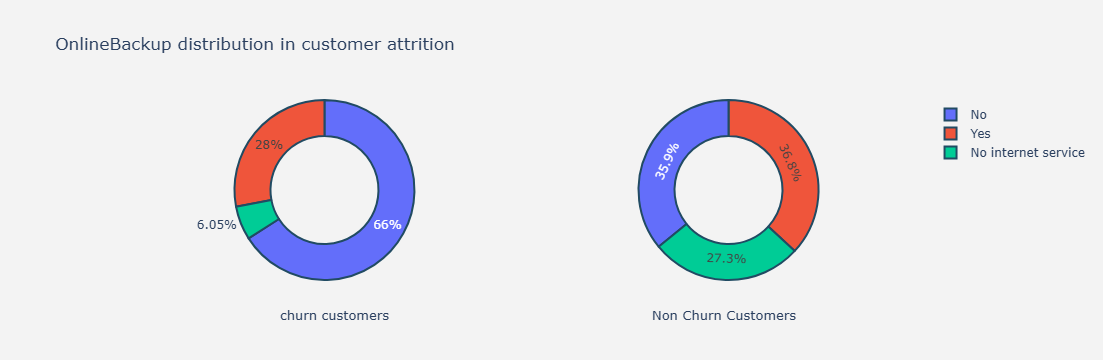

Null Hypothesis (H0): OnlineBackup and churn are independent (OnlineBackup has no effect on whether a customer churns).
Alternative Hypothesis (Ha): OnlineBackup and churn are not independent (OnlineBackup has a significant effect on whether a customer churns).


Churn,No,Yes,All
OnlineBackup,,,
No,1855,1233,3088
No internet service,1413,113,1526
Yes,1906,523,2429
All,5174,1869,7043


Chi-Square Statistic: 601.8127901134089
p-value: 9.47834366883598e-127
🟩 Reject the null hypothesis: OnlineBackup and churn are not independent (OnlineBackup has a significant effect on whether a customer churns).


In [308]:
plot_pie("OnlineBackup")
chi_square_test('OnlineBackup', df)

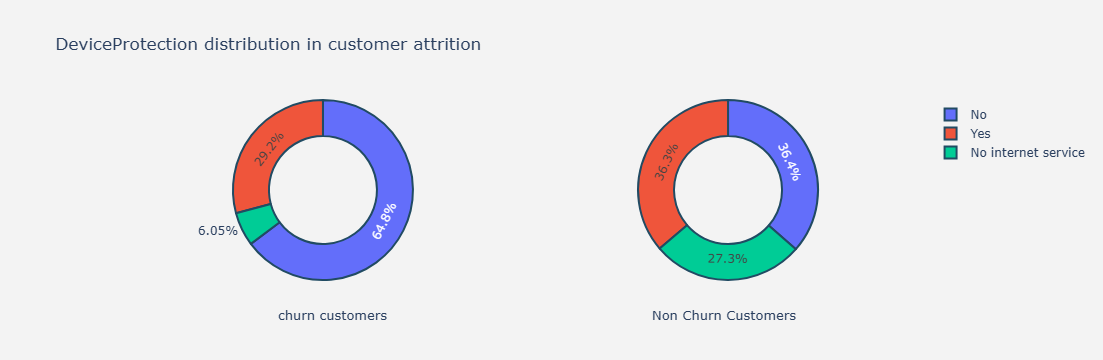

Null Hypothesis (H0): DeviceProtection and churn are independent (DeviceProtection has no effect on whether a customer churns).
Alternative Hypothesis (Ha): DeviceProtection and churn are not independent (DeviceProtection has a significant effect on whether a customer churns).


Churn,No,Yes,All
DeviceProtection,,,
No,1884,1211,3095
No internet service,1413,113,1526
Yes,1877,545,2422
All,5174,1869,7043


Chi-Square Statistic: 558.419369407389
p-value: 2.1613069878600708e-117
🟩 Reject the null hypothesis: DeviceProtection and churn are not independent (DeviceProtection has a significant effect on whether a customer churns).


In [309]:
plot_pie('DeviceProtection')
chi_square_test('DeviceProtection', df)

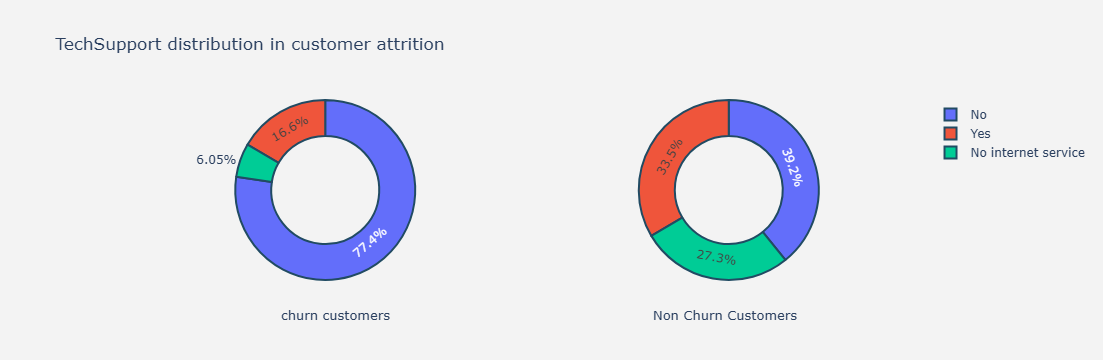

Null Hypothesis (H0): TechSupport and churn are independent (TechSupport has no effect on whether a customer churns).
Alternative Hypothesis (Ha): TechSupport and churn are not independent (TechSupport has a significant effect on whether a customer churns).


Churn,No,Yes,All
TechSupport,,,
No,2027,1446,3473
No internet service,1413,113,1526
Yes,1734,310,2044
All,5174,1869,7043


Chi-Square Statistic: 828.1970684587393
p-value: 1.2432731207524936e-175
🟩 Reject the null hypothesis: TechSupport and churn are not independent (TechSupport has a significant effect on whether a customer churns).


In [310]:
plot_pie('TechSupport')
chi_square_test('TechSupport', df)

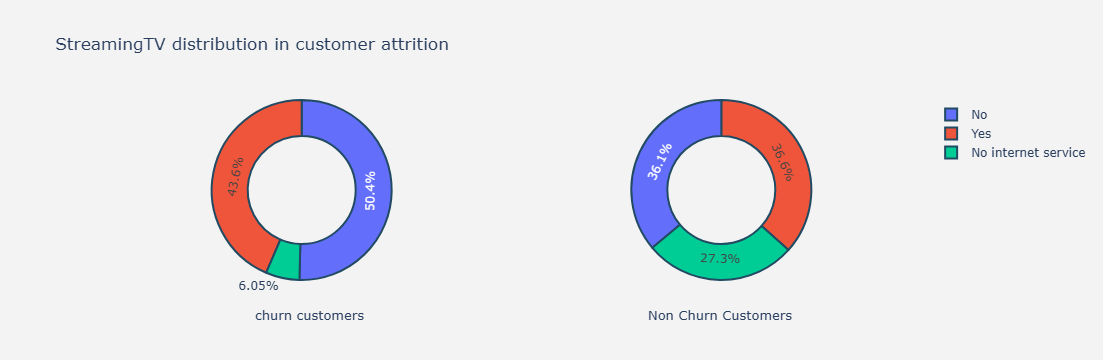

Null Hypothesis (H0): StreamingTV and churn are independent (StreamingTV has no effect on whether a customer churns).
Alternative Hypothesis (Ha): StreamingTV and churn are not independent (StreamingTV has a significant effect on whether a customer churns).


Churn,No,Yes,All
StreamingTV,,,
No,1868,942,2810
No internet service,1413,113,1526
Yes,1893,814,2707
All,5174,1869,7043


Chi-Square Statistic: 374.2039433109813
p-value: 9.781717833060411e-78
🟩 Reject the null hypothesis: StreamingTV and churn are not independent (StreamingTV has a significant effect on whether a customer churns).


In [311]:
plot_pie('StreamingTV')
chi_square_test('StreamingTV', df)

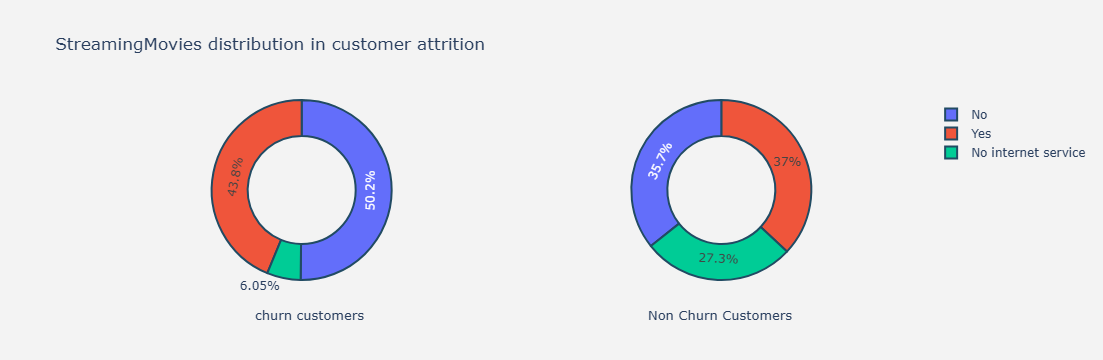

Null Hypothesis (H0): StreamingMovies and churn are independent (StreamingMovies has no effect on whether a customer churns).
Alternative Hypothesis (Ha): StreamingMovies and churn are not independent (StreamingMovies has a significant effect on whether a customer churns).


Churn,No,Yes,All
StreamingMovies,,,
No,1847,938,2785
No internet service,1413,113,1526
Yes,1914,818,2732
All,5174,1869,7043


Chi-Square Statistic: 375.66147934526555
p-value: 4.756349955118015e-78
🟩 Reject the null hypothesis: StreamingMovies and churn are not independent (StreamingMovies has a significant effect on whether a customer churns).


In [312]:
plot_pie('StreamingMovies')
chi_square_test('StreamingMovies', df)

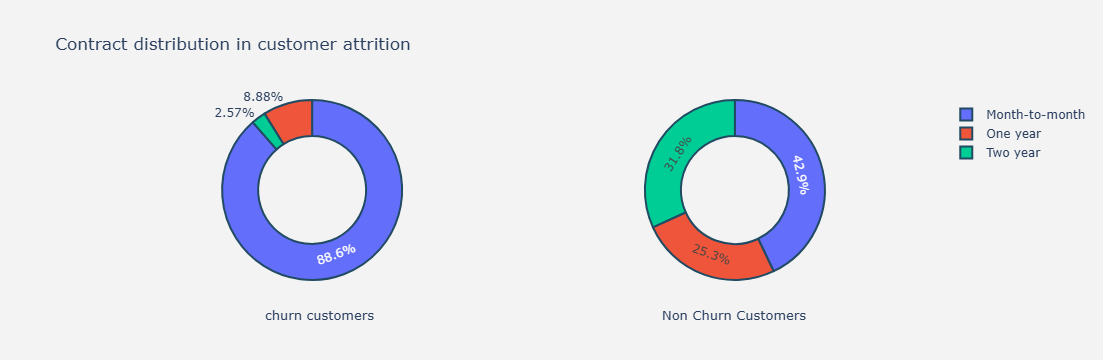

Null Hypothesis (H0): Contract and churn are independent (Contract has no effect on whether a customer churns).
Alternative Hypothesis (Ha): Contract and churn are not independent (Contract has a significant effect on whether a customer churns).


Churn,No,Yes,All
Contract,,,
Month-to-month,2220,1655,3875
One year,1307,166,1473
Two year,1647,48,1695
All,5174,1869,7043


Chi-Square Statistic: 1184.5965720837926
p-value: 1.0319060455020843e-252
🟩 Reject the null hypothesis: Contract and churn are not independent (Contract has a significant effect on whether a customer churns).


In [313]:
plot_pie('Contract')
chi_square_test('Contract', df)

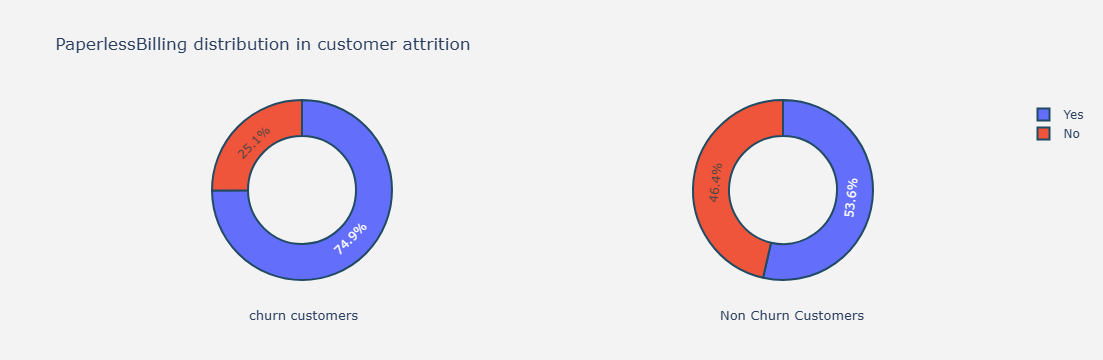

Null Hypothesis (H0): PaperlessBilling and churn are independent (PaperlessBilling has no effect on whether a customer churns).
Alternative Hypothesis (Ha): PaperlessBilling and churn are not independent (PaperlessBilling has a significant effect on whether a customer churns).


Churn,No,Yes,All
PaperlessBilling,,,
No,2403,469,2872
Yes,2771,1400,4171
All,5174,1869,7043


Chi-Square Statistic: 259.1609742710177
p-value: 6.914929538933956e-55
🟩 Reject the null hypothesis: PaperlessBilling and churn are not independent (PaperlessBilling has a significant effect on whether a customer churns).


In [314]:
plot_pie('PaperlessBilling')
chi_square_test('PaperlessBilling', df)

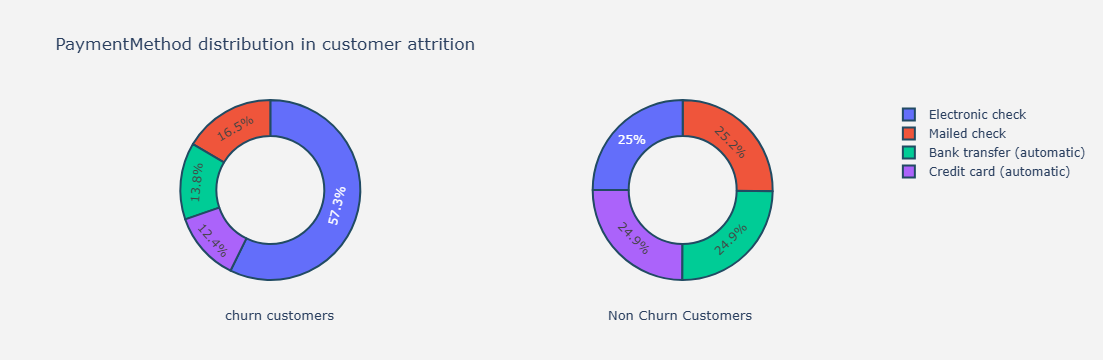

Null Hypothesis (H0): PaymentMethod and churn are independent (PaymentMethod has no effect on whether a customer churns).
Alternative Hypothesis (Ha): PaymentMethod and churn are not independent (PaymentMethod has a significant effect on whether a customer churns).


Churn,No,Yes,All
PaymentMethod,,,
Bank transfer (automatic),1286,258,1544
Credit card (automatic),1290,232,1522
Electronic check,1294,1071,2365
Mailed check,1304,308,1612
All,5174,1869,7043


Chi-Square Statistic: 648.1423274814001
p-value: 1.0362827902735449e-134
🟩 Reject the null hypothesis: PaymentMethod and churn are not independent (PaymentMethod has a significant effect on whether a customer churns).


In [315]:
plot_pie('PaymentMethod')
chi_square_test('PaymentMethod', df)

Statistical inferences regarding churn with respect to each variable:

1. **`TechSupport`**: 77.4% of customers without tech support churned, indicating a strong correlation between lack of support and churn.

2. **`DeviceProtection`**: 64.8% of customers without device protection churned, showing a significant link between lack of protection and churn.

3. **`OnlineBackup`**: 66% of customers without online backup churned, highlighting a significant association between the absence of backup services and higher churn rates.

4. **`OnlineSecurity`**: 78.2% of customers without online security churned, emphasizing the importance of online security in reducing churn.

5. **`InternetService`**: 69.4% of customers with fiber optic internet service churned, showing that this service type is more prone to churn compared to others.

6. **`MultipleLines`**: Churn is nearly evenly distributed among customers with and without multiple lines, indicating no significant impact of this variable on churn.

7. **`PhoneService`**: Phone service shows minimal impact on churn, with nearly identical churn rates for customers with and without the service.

8. **`Dependents`**: 82.6% of customers without dependents churned, suggesting that having dependents is associated with lower churn rates.

9. **`Partner`**: 64.2% of customers without partners churned, indicating that having a partner may reduce the likelihood of churn.

10. **`SeniorCitizen`**: 25.5% of senior citizens churned, a significant proportion compared to non-senior citizens, showing age as a churn factor.

11. **`PaymentMethod`**: 57.3% of churned customers used electronic check, highlighting this payment method's strong association with churn.

12. **`PaperlessBilling`**: 74.9% of churned customers opted for paperless billing, showing a strong correlation between paperless billing and churn.

13. **`Contract`**: 88.6% of churned customers were on a month-to-month contract, indicating that long-term contracts are associated with lower churn rates.

14. **`StreamingMovies`**: 50.2% of churned customers did not use streaming movies, suggesting that streaming service usage does not significantly impact churn.

15. **`StreamingTV`**: 50.4% of churned customers did not use streaming TV, indicating that streaming TV usage has a minimal impact on churn.

# Customer Churn Characteristics

🔴 **Lack of Tech Support**: Customers without tech support have a higher likelihood of churning.

🔴 **No Device Protection**: Customers without device protection are more prone to churn.

🔴 **No Online Backup**: The absence of online backup services is associated with a higher churn rate.

🔴 **No Online Security**: Customers without online security are significantly more likely to churn.

🔴 **Fiber Optic Internet Service**: Customers using fiber optic internet service are more likely to churn compared to those using other types of internet services.

🔴 **No Dependents**: Customers without dependents have a higher probability of churning.

🔴 **No Partner**: Customers who do not have a partner are more likely to churn.

🔴 **Electronic Check Payment**: Customers who use electronic checks as their payment method are more likely to churn.

🔴 **Paperless Billing**: Customers who opt for paperless billing are more likely to churn.

🔴 **Month-to-Month Contract**: Customers on month-to-month contracts are highly likely to churn, compared to those with longer-term contracts.

### Summary:
Customers who are most likely to churn tend to lack various support and protection services, prefer month-to-month contracts, use electronic check payments, and opt for paperless billing. These characteristics suggest that customers who feel less secure or committed (due to lack of support services or long-term contracts) are more prone to leaving.

The combined table with all features and their significance:

| **Feature**           | **p-value**         | **Significance**              |
|-----------------------|---------------------|-------------------------------|
| **SeniorCitizen**      | 1.23e-33            | Significant                   |
| **Partner**            | 1.95e-33            | Significant                   |
| **Dependents**         | 5.46e-40            | Significant                   |
| **InternetService**    | 6.45e-155           | Significant                   |
| **OnlineSecurity**     | 2.41e-180           | Significant                   |
| **OnlineBackup**       | 9.48e-127           | Significant                   |
| **DeviceProtection**   | 2.16e-117           | Significant                   |
| **TechSupport**        | 1.24e-175           | Significant                   |
| **StreamingTV**        | 9.78e-78            | Significant                   |
| **StreamingMovies**    | 4.76e-78            | Significant                   |
| **Contract**           | 1.03e-252           | Significant                   |
| **PaperlessBilling**   | 6.91e-55            | Significant                   |
| **PaymentMethod**      | 1.04e-134           | Significant                   |
| **Gender**             | 0.971               | Not Significant               |
| **PhoneService**       | 0.909               | Not Significant               |
| **MultipleLines**      | 0.079               | Not Significant               |

### Explanation:
- This table lists all the features along with their associated p-values and indicates whether they have a significant impact on customer churn or not.
- Features with a **Significant** label have a p-value less than 0.05, indicating that they are statistically significant for predicting churn.
- Features with a **Not Significant** label have a p-value greater than 0.05, indicating that they do not have a statistically significant impact on churn.

In [319]:
import plotly.graph_objects as go
import pandas as pd

def plot_area_chart(df, column):
    """
    Function to plot an area chart for the distribution of a specified column 
    with respect to customer churn.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    column (str): The column for which the area chart is to be plotted.

    """
    # Aggregate the data to get percentage of churn and non-churn customers for each value in the column
    churn_data = df[df['Churn'] == 'Yes'][column].value_counts(normalize=True).sort_index() * 100
    non_churn_data = df[df['Churn'] == 'No'][column].value_counts(normalize=True).sort_index() * 100

    # Create area chart using plotly
    fig = go.Figure()

    # Adding Churn customers data to the chart
    fig.add_trace(go.Scatter(
        x=churn_data.index, y=churn_data.values,
        mode='lines',
        name='Churn Customers',
        fill='tozeroy',
        line=dict(color='red')
    ))

    # Adding Non-Churn customers data to the chart
    fig.add_trace(go.Scatter(
        x=non_churn_data.index, y=non_churn_data.values,
        mode='lines',
        name='Non Churn Customers',
        fill='tozeroy',
        line=dict(color='blue')
    ))

    # Update layout
    fig.update_layout(
        title=f'{column} Distribution in Customer Attrition',
        xaxis_title=column,
        yaxis_title='Percent',
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray'),
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray')
    )

    fig.show()

# Example usage:
# plot_area_chart(df, 'tenure')


In [320]:

def test_churn_significance(df, variable):
    """
    Function to test the significance of churn with respect to a given numerical variable using the Mann-Whitney U Test.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    variable (str): The column name of the variable to be tested.

    Returns:
    None: Prints the test statistic, p-value, and the hypothesis test result.
    """

    # Hypotheses
    h0 = f"Churn and {variable} are independent (no effect on churn)."
    ha = f"Churn and {variable} are not independent (significant effect on churn)."

    # Significance level
    alpha = 0.05

    # Split the data into two groups based on 'Churn'
    churn_yes = df[df['Churn'] == 'Yes']
    churn_no = df[df['Churn'] == 'No']

    # Perform the Mann-Whitney U Test
    stat, p = stats.mannwhitneyu(churn_yes[variable], churn_no[variable])

    # Print the results
    print(f'{variable} - U Statistic: {stat}, p-value: {p}')
    result = ("🟩 Reject the null hypothesis: " + ha) if p < alpha else ("🟥 Fail to reject the null hypothesis: " + h0)
    print(result)
    print("\n")

# Example usage:
# test_churn_significance(df, 'tenure')
# test_churn_significance(df, 'MonthlyCharges')
# test_churn_significance(df, 'TotalCharges')


In [321]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

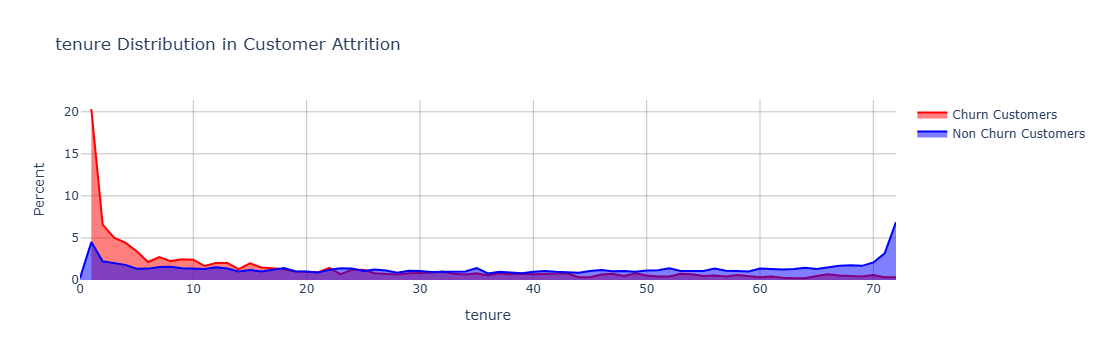

In [322]:
plot_area_chart(df, 'tenure')

🔴 Customers with shorter tenure (especially less than 10 months) are more likely to churn, as indicated by the higher proportion of churned customers within this group.

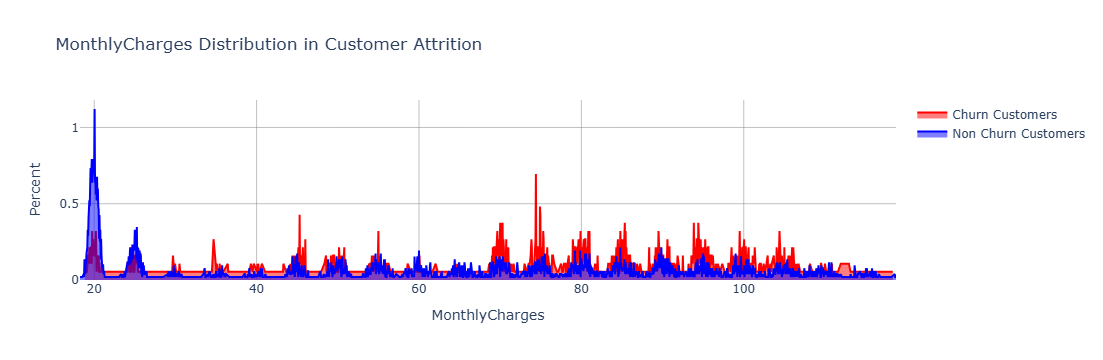

In [324]:
plot_area_chart(df, 'MonthlyCharges')

🔴 Customers with higher monthly charges (especially above $70) are more likely to churn, as indicated by the increased density of churned customers in this range.

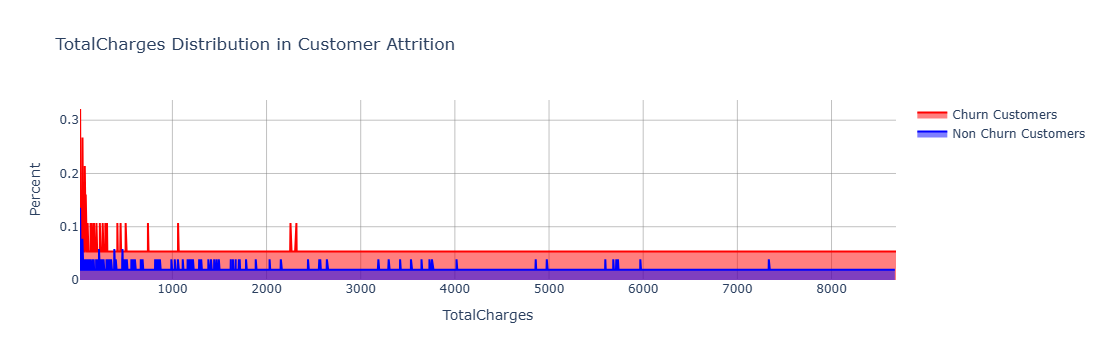

In [326]:
plot_area_chart(df, 'TotalCharges')

🔴 Customers with lower total charges, particularly those under $1,000, are more likely to churn, as indicated by the higher density of churned customers in this range.

In [328]:
test_churn_significance(df, 'tenure')
test_churn_significance(df, 'MonthlyCharges')
test_churn_significance(df, 'TotalCharges')

tenure - U Statistic: 2515538.0, p-value: 2.419635517951866e-208
🟩 Reject the null hypothesis: Churn and tenure are not independent (significant effect on churn).


MonthlyCharges - U Statistic: 6003125.5, p-value: 3.311627651988585e-54
🟩 Reject the null hypothesis: Churn and MonthlyCharges are not independent (significant effect on churn).


TotalCharges - U Statistic: nan, p-value: nan
🟥 Fail to reject the null hypothesis: Churn and TotalCharges are independent (no effect on churn).




| Feature          | p-value             | Significance       |
|------------------|---------------------|--------------------|
| tenure           | 2.42e-208           | Significant        |
| MonthlyCharges   | 3.31e-54            | Significant        |
| TotalCharges     | NaN                 | Not Significant    |


In [330]:
# month charges vs total charges vs tenure on churn and not churn

<Axes: xlabel='MonthlyCharges', ylabel='TotalCharges'>

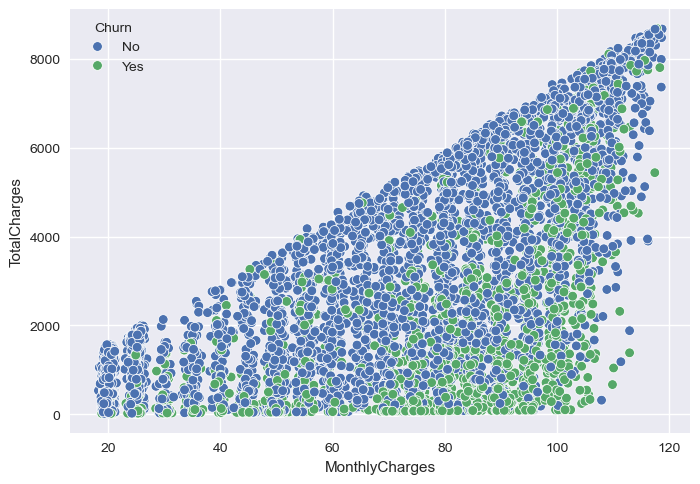

In [331]:
sns.scatterplot(x=df.MonthlyCharges,
                y=df.TotalCharges,
                hue = df.Churn)

# need to adjust the opacity

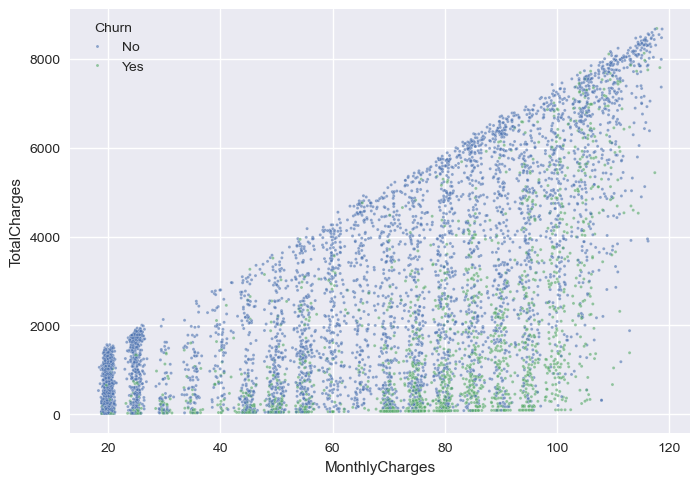

In [332]:
sns.scatterplot(
    x=df.MonthlyCharges,
    y=df.TotalCharges,
    hue=df.Churn,
    alpha=0.6,
    s=5  # Reduce the marker size
)
plt.show()


Inferences from the scatter plot:

1. **Positive Correlation**: There is a clear positive correlation between `MonthlyCharges` and `TotalCharges`. As monthly charges increase, total charges also increase.

2. **Churn Distribution**: Customers who churn (`Yes`) are spread across all levels of `MonthlyCharges`, but they appear more frequently at lower `TotalCharges` values, indicating that those who churn often have not accumulated large total charges.

3. **Overlap of Churn Status**: There is significant overlap between customers who churn and those who do not, particularly in the middle range of `MonthlyCharges` and `TotalCharges`, suggesting that churn is not solely dependent on these two factors.

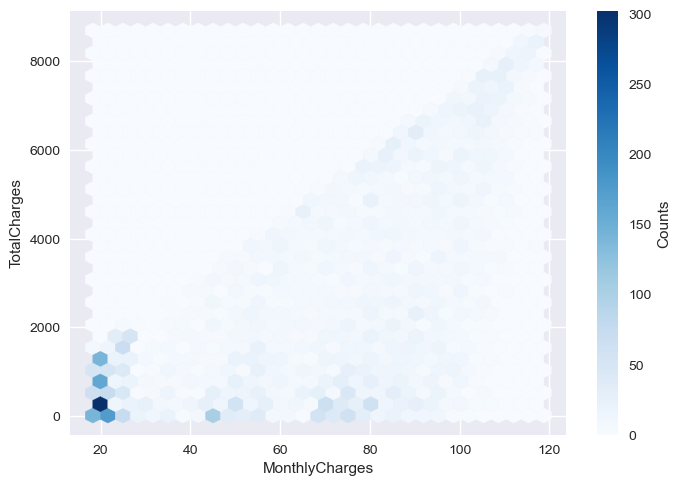

In [334]:
plt.hexbin(
    x=df.MonthlyCharges,
    y=df.TotalCharges,
    gridsize=30,  # Adjust the grid size
    cmap='Blues',  # Choose a color map
    alpha=1
)
plt.colorbar(label='Counts')
plt.xlabel('MonthlyCharges')
plt.ylabel('TotalCharges')
plt.show()


# Feature Selection

In [336]:
# List of significant features
significant_features = [
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "tenure",
    "MonthlyCharges"
]

# Loop through each significant feature and print unique values
for feature in significant_features:
    unique_values = df[feature].unique()
    print(f'Unique values for {feature}: {unique_values}\n')


Unique values for SeniorCitizen: [0 1]

Unique values for Partner: ['Yes' 'No']

Unique values for Dependents: ['No' 'Yes']

Unique values for InternetService: ['DSL' 'Fiber optic' 'No']

Unique values for OnlineSecurity: ['No' 'Yes' 'No internet service']

Unique values for OnlineBackup: ['Yes' 'No' 'No internet service']

Unique values for DeviceProtection: ['No' 'Yes' 'No internet service']

Unique values for TechSupport: ['No' 'Yes' 'No internet service']

Unique values for StreamingTV: ['No' 'Yes' 'No internet service']

Unique values for StreamingMovies: ['No' 'Yes' 'No internet service']

Unique values for Contract: ['Month-to-month' 'One year' 'Two year']

Unique values for PaperlessBilling: ['Yes' 'No']

Unique values for PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Unique values for tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 4

In [337]:
from sklearn.preprocessing import MinMaxScaler

# Ensure df['Churn'] is converted correctly to numeric, but only if not done already
if df['Churn'].dtype != 'int64':
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Check the data type of Churn to ensure it's numeric
print(f"Data type of Churn: {df['Churn'].dtype}")

# List of categorical features
categorical_features = [
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod"
]

# Define the ID and response columns
id_col = ['customerID']
response_col = ['Churn']

# Initialize df_model with only ID and response columns
df_model = df[id_col + response_col].copy()

# Perform target encoding for each categorical feature and save to df_model
for feature in categorical_features:
    # Ensure the feature is treated as a categorical variable
    if df[feature].dtype != 'object':
        df[feature] = df[feature].astype(str)
    
    # Calculate the mean churn for each category in the feature
    target_mean = df.groupby(feature)['Churn'].mean()
    
    # Debug: Print the target mean to ensure it's calculated correctly
    print(f"Target mean for {feature}:", target_mean, "\n\n")
    
    # Map the mean churn back to the feature and add to df_model
    df_model[feature + '_encoded'] = df[feature].map(target_mean)

# Select the numerical features to scale
numerical_features = ["tenure", "MonthlyCharges"]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Perform scaling on numerical features and add to df_model
for feature in numerical_features:
    df_model[feature + '_scaled'] = scaler.fit_transform(df[[feature]])



Data type of Churn: int64
Target mean for SeniorCitizen: SeniorCitizen
0    0.236062
1    0.416813
Name: Churn, dtype: float64 


Target mean for Partner: Partner
No     0.329580
Yes    0.196649
Name: Churn, dtype: float64 


Target mean for Dependents: Dependents
No     0.312791
Yes    0.154502
Name: Churn, dtype: float64 


Target mean for InternetService: InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
Name: Churn, dtype: float64 


Target mean for OnlineSecurity: OnlineSecurity
No                     0.417667
No internet service    0.074050
Yes                    0.146112
Name: Churn, dtype: float64 


Target mean for OnlineBackup: OnlineBackup
No                     0.399288
No internet service    0.074050
Yes                    0.215315
Name: Churn, dtype: float64 


Target mean for DeviceProtection: DeviceProtection
No                     0.391276
No internet service    0.074050
Yes                    0.225021
Name: Churn, dtype: float64 


In [338]:
# Display the first few rows to check the result
display(df_model.head(9).T)

,0,1,2,3,4,5,6,7,8
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP
Churn,0,0,1,0,1,1,0,0,1
SeniorCitizen_encoded,0.236062,0.236062,0.236062,0.236062,0.236062,0.236062,0.236062,0.236062,0.236062
Partner_encoded,0.196649,0.32958,0.32958,0.32958,0.32958,0.32958,0.32958,0.32958,0.196649
Dependents_encoded,0.312791,0.312791,0.312791,0.312791,0.312791,0.312791,0.154502,0.312791,0.312791
InternetService_encoded,0.189591,0.189591,0.189591,0.189591,0.418928,0.418928,0.418928,0.189591,0.418928
OnlineSecurity_encoded,0.417667,0.146112,0.146112,0.146112,0.417667,0.417667,0.417667,0.146112,0.417667
OnlineBackup_encoded,0.215315,0.399288,0.215315,0.399288,0.399288,0.399288,0.215315,0.399288,0.399288
DeviceProtection_encoded,0.391276,0.225021,0.391276,0.225021,0.391276,0.225021,0.391276,0.391276,0.225021
TechSupport_encoded,0.416355,0.416355,0.416355,0.151663,0.416355,0.416355,0.416355,0.416355,0.151663


In [339]:
df_model.describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,7043.0,0.265370,0.441561,0.000000,0.000000,0.000000,1.000000,1.000000
SeniorCitizen_encoded,7043.0,0.265370,0.066627,0.236062,0.236062,0.236062,0.236062,0.416813
Partner_encoded,7043.0,0.265370,0.066432,0.196649,0.196649,0.329580,0.329580,0.329580
Dependents_encoded,7043.0,0.265370,0.072514,0.154502,0.154502,0.312791,0.312791,0.312791
InternetService_encoded,7043.0,0.265370,0.142383,0.074050,0.189591,0.189591,0.418928,0.418928
OnlineSecurity_encoded,7043.0,0.265370,0.153399,0.074050,0.146112,0.146112,0.417667,0.417667
OnlineBackup_encoded,7043.0,0.265370,0.129075,0.074050,0.215315,0.215315,0.399288,0.399288
DeviceProtection_encoded,7043.0,0.265370,0.124335,0.074050,0.225021,0.225021,0.391276,0.391276
TechSupport_encoded,7043.0,0.265370,0.151419,0.074050,0.151663,0.151663,0.416355,0.416355
StreamingTV_encoded,7043.0,0.265370,0.101781,0.074050,0.300702,0.300702,0.335231,0.335231


# Customer Churn Classification:

In [341]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_and_evaluate_model(df_model, model, test_size=0.3, random_state=42):
    """
    Train and evaluate a machine learning model on the given DataFrame.

    Parameters:
    df_model (DataFrame): The DataFrame containing features and target.
    model (sklearn estimator): The machine learning model to use for training.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
    None: Prints the confusion matrix, classification report, and accuracy score.
    """
    # Features and target
    X = df_model.drop(columns=['customerID', 'Churn'])
    y = df_model['Churn']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

In [342]:


print("🧮🧮 Logistic Regression")
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(max_iter=1000)
train_and_evaluate_model(df_model, logistic_regression_model)


🧮🧮 Logistic Regression
Confusion Matrix:
[[1389  150]
 [ 264  310]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1539
           1       0.67      0.54      0.60       574

    accuracy                           0.80      2113
   macro avg       0.76      0.72      0.73      2113
weighted avg       0.80      0.80      0.80      2113

Accuracy: 0.80


In [343]:


print("🧮🧮 Random Forest")
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)
train_and_evaluate_model(df_model, random_forest_model)


🧮🧮 Random Forest
Confusion Matrix:
[[1392  147]
 [ 294  280]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1539
           1       0.66      0.49      0.56       574

    accuracy                           0.79      2113
   macro avg       0.74      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113

Accuracy: 0.79


In [344]:


print("🧮🧮 SVM")
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')  # You can choose different kernels (e.g., 'linear', 'rbf')
train_and_evaluate_model(df_model, svm_model)


🧮🧮 SVM
Confusion Matrix:
[[1387  152]
 [ 258  316]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1539
           1       0.68      0.55      0.61       574

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113

Accuracy: 0.81


In [345]:
# pip install xgboost

In [346]:


print("🧮🧮 XGBoost")
from xgboost import XGBClassifier
xgboost_model = XGBClassifier(random_state=42)
train_and_evaluate_model(df_model, xgboost_model)


🧮🧮 XGBoost
Confusion Matrix:
[[1365  174]
 [ 283  291]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1539
           1       0.63      0.51      0.56       574

    accuracy                           0.78      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.77      0.78      0.78      2113

Accuracy: 0.78


In [347]:


print("🧮🧮 K-Nearest Neighbors")
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can choose different values for n_neighbors
train_and_evaluate_model(df_model, knn_model)


🧮🧮 K-Nearest Neighbors
Confusion Matrix:
[[1341  198]
 [ 285  289]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1539
           1       0.59      0.50      0.54       574

    accuracy                           0.77      2113
   macro avg       0.71      0.69      0.70      2113
weighted avg       0.76      0.77      0.77      2113

Accuracy: 0.77


In [348]:
###################################
# Feature extraction
###################################

# Feature based on the customer's gender and senior
df.loc[((df['gender'] == 'Male') & (df['SeniorCitizen']== 1)), 'SENIOR/YOUNG_GENDER'] ='senior_male'
df.loc[((df['gender'] == 'Male') & (df['SeniorCitizen']== 0)), 'SENIOR/YOUNG_GENDER'] ='young_male'
df.loc[((df['gender'] == 'Female') & (df['SeniorCitizen']== 1)), 'SENIOR/YOUNG_GENDER'] ='senior_female'
df.loc[((df['gender'] == 'Female') & (df['SeniorCitizen']== 0)), 'SENIOR/YOUNG_GENDER'] ='young_female'
df.groupby('SENIOR/YOUNG_GENDER').agg({'Churn': ['mean','count']})


Empty DataFrame
Columns: [(Churn, mean), (Churn, count)]
Index: []